In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [5]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [7]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [8]:
no_fx = [i for i in data.columns if i not in d_map['Currencies']]
PPCA=p.PPCA()
PPCA.fit(np.array(data[no_fx]),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(sector_zscores[sect].index)
    pcs[i]=x
sector_PC['Total'] = pcs

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [11]:
sector_PC.keys()

['Agriculturals',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income',
 'Total']

# Canonical Correlations of common factors

The sample includes XXX markets across YY asset classes.  Source: Reuters and Quandl.

In [12]:
prin_factors=pd.DataFrame()
for sector in ['Agriculturals',
                 'Energies',
                 'Equities',
                 'Metals',
                 'Fixed Income',
                 'Total']:
    prin_factors['Amihud '+sector]=sector_PC[sector].mean(axis=1)
    

# FHT method

In [13]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [14]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [15]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [16]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [17]:
PPCA=p.PPCA()
PPCA.fit(np.array(data),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(sector_zscores[sect].index)
    pcs[i]=x
sector_PC['Total'] = pcs


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  import sys


In [18]:
for sector in sector_PC.keys():
    prin_factors['FHT '+sector]=sector_PC[sector][0]

# Presentation

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


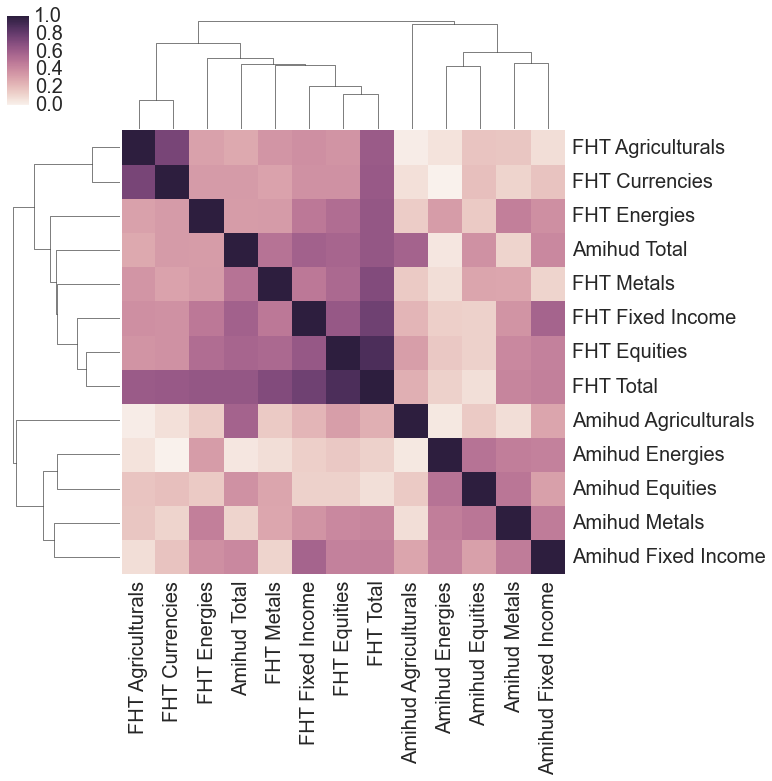

In [19]:
sns.clustermap(prin_factors.corr().abs())

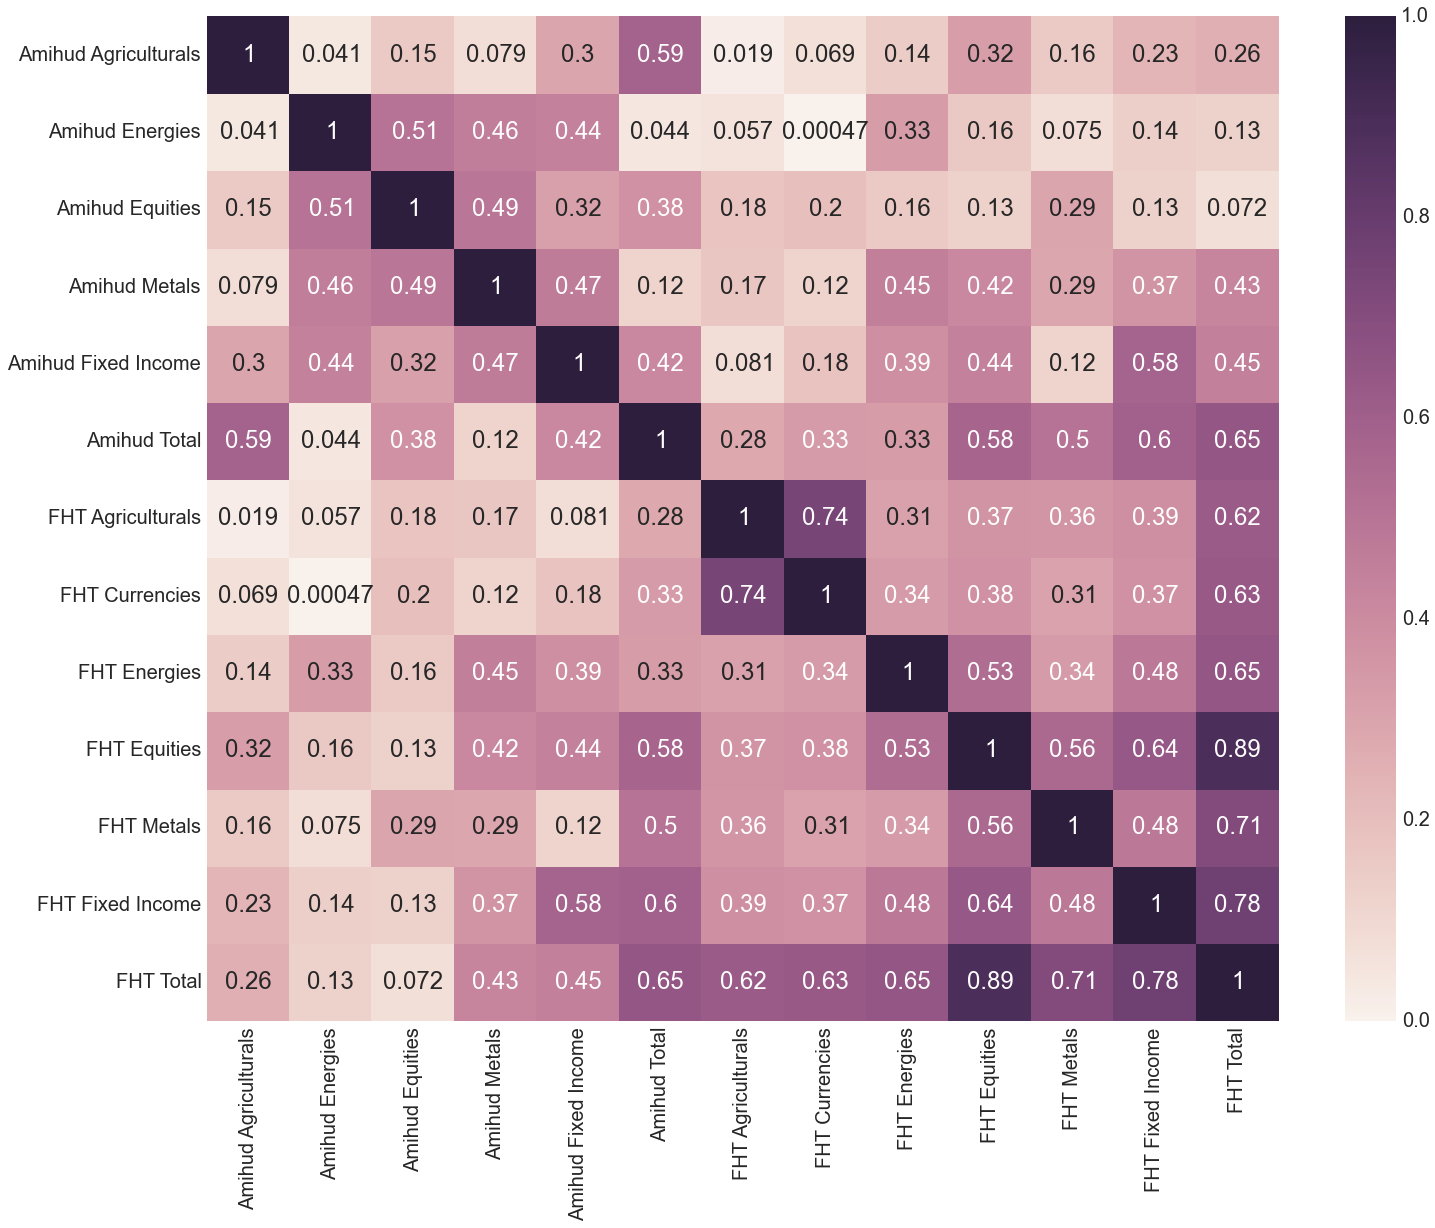

In [20]:
sns.heatmap(prin_factors.corr().abs(),annot=True)

In [21]:
print prin_factors.corr().abs().round(2).to_latex()

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  Amihud Agriculturals &  Amihud Energies &  Amihud Equities &  Amihud Metals &  Amihud Fixed Income &  Amihud Total &  FHT Agriculturals &  FHT Currencies &  FHT Energies &  FHT Equities &  FHT Metals &  FHT Fixed Income &  FHT Total \\
\midrule
Amihud Agriculturals &                  1.00 &             0.04 &             0.15 &           0.08 &                 0.30 &          0.59 &               0.02 &            0.07 &          0.14 &          0.32 &        0.16 &              0.23 &       0.26 \\
Amihud Energies      &                  0.04 &             1.00 &             0.51 &           0.46 &                 0.44 &          0.04 &               0.06 &            0.00 &          0.33 &          0.16 &        0.08 &              0.14 &       0.13 \\
Amihud Equities      &                  0.15 &             0.51 &             1.00 &           0.49 &                 0.32 &          0.38 &               0.18 &            0.20 &         

In [22]:
prin_factors.corr().abs().round(2)

,Amihud Agriculturals,Amihud Energies,Amihud Equities,Amihud Metals,Amihud Fixed Income,Amihud Total,FHT Agriculturals,FHT Currencies,FHT Energies,FHT Equities,FHT Metals,FHT Fixed Income,FHT Total
Amihud Agriculturals,1.00,0.04,0.15,0.08,0.30,0.59,0.02,0.07,0.14,0.32,0.16,0.23,0.26
Amihud Energies,0.04,1.00,0.51,0.46,0.44,0.04,0.06,0.00,0.33,0.16,0.08,0.14,0.13
Amihud Equities,0.15,0.51,1.00,0.49,0.32,0.38,0.18,0.20,0.16,0.13,0.29,0.13,0.07
Amihud Metals,0.08,0.46,0.49,1.00,0.47,0.12,0.17,0.12,0.45,0.42,0.29,0.37,0.43
Amihud Fixed Income,0.30,0.44,0.32,0.47,1.00,0.42,0.08,0.18,0.39,0.44,0.12,0.58,0.45
Amihud Total,0.59,0.04,0.38,0.12,0.42,1.00,0.28,0.33,0.33,0.58,0.50,0.60,0.65
FHT Agriculturals,0.02,0.06,0.18,0.17,0.08,0.28,1.00,0.74,0.31,0.37,0.36,0.39,0.62
FHT Currencies,0.07,0.00,0.20,0.12,0.18,0.33,0.74,1.00,0.34,0.38,0.31,0.37,0.63
FHT Energies,0.14,0.33,0.16,0.45,0.39,0.33,0.31,0.34,1.00,0.53,0.34,0.48,0.65
FHT Equities,0.32,0.16,0.13,0.42,0.44,0.58,0.37,0.38,0.53,1.00,0.56,0.64,0.89
